In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import (
    load_cleaned_russian_text_data,
    get_class_weights,
    get_initial_output_bias,
    evaluate_model,
    SEED
)
from wordEmbeddingsLayers import universal_sentence_encoder_layer, USE_SENTENCE_EMBEDDING_DIMENSION

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Build CNN model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [4]:
from tensorflow.keras import layers, losses

negative_class_amount, pos_class_amount = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    get_initial_output_bias(pos_class_amount, negative_class_amount)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    universal_sentence_encoder_layer,
    
    layers.Reshape((USE_SENTENCE_EMBEDDING_DIMENSION, 1)),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.GlobalMaxPool1D(),
    
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(rate=0.5, seed=SEED),
    
    layers.Dense(units=1, bias_initializer=initial_output_bias),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, т.к. на выходе layers.Activation('sigmoid')
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [5]:
epochs = 10
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=2**9,
    validation_split=0.2, # сколько от тестовой выборки отрезать под валидационную
#     callbacks=[early_stopping],
    class_weight=get_class_weights(pos_class_amount, negative_class_amount),
)

Epoch 1/10
19/19 [==============================] - 56s 2s/step - loss: 0.7332 - binary_accuracy: 0.6640 - recall: 0.0396 - precision: 0.3926 - val_loss: 0.6181 - val_binary_accuracy: 0.8677 - val_recall: 0.8138 - val_precision: 0.7942
Epoch 2/10
19/19 [==============================] - 44s 2s/step - loss: 0.5823 - binary_accuracy: 0.8723 - recall: 0.8605 - precision: 0.7853 - val_loss: 0.6047 - val_binary_accuracy: 0.8105 - val_recall: 0.9453 - val_precision: 0.6476
Epoch 3/10
19/19 [==============================] - 44s 2s/step - loss: 0.4441 - binary_accuracy: 0.9078 - recall: 0.9281 - precision: 0.8221 - val_loss: 0.4404 - val_binary_accuracy: 0.8920 - val_recall: 0.8047 - val_precision: 0.8619
Epoch 4/10
19/19 [==============================] - 44s 2s/step - loss: 0.3180 - binary_accuracy: 0.9430 - recall: 0.9298 - precision: 0.9056 - val_loss: 0.4627 - val_binary_accuracy: 0.8951 - val_recall: 0.8776 - val_precision: 0.8200
Epoch 5/10
19/19 [==============================] - 43s 

# Model evaluation

Accuracy: 90.39%
Recall: 85.32%
Precision: 85.59%
F1-score: 85.46% 



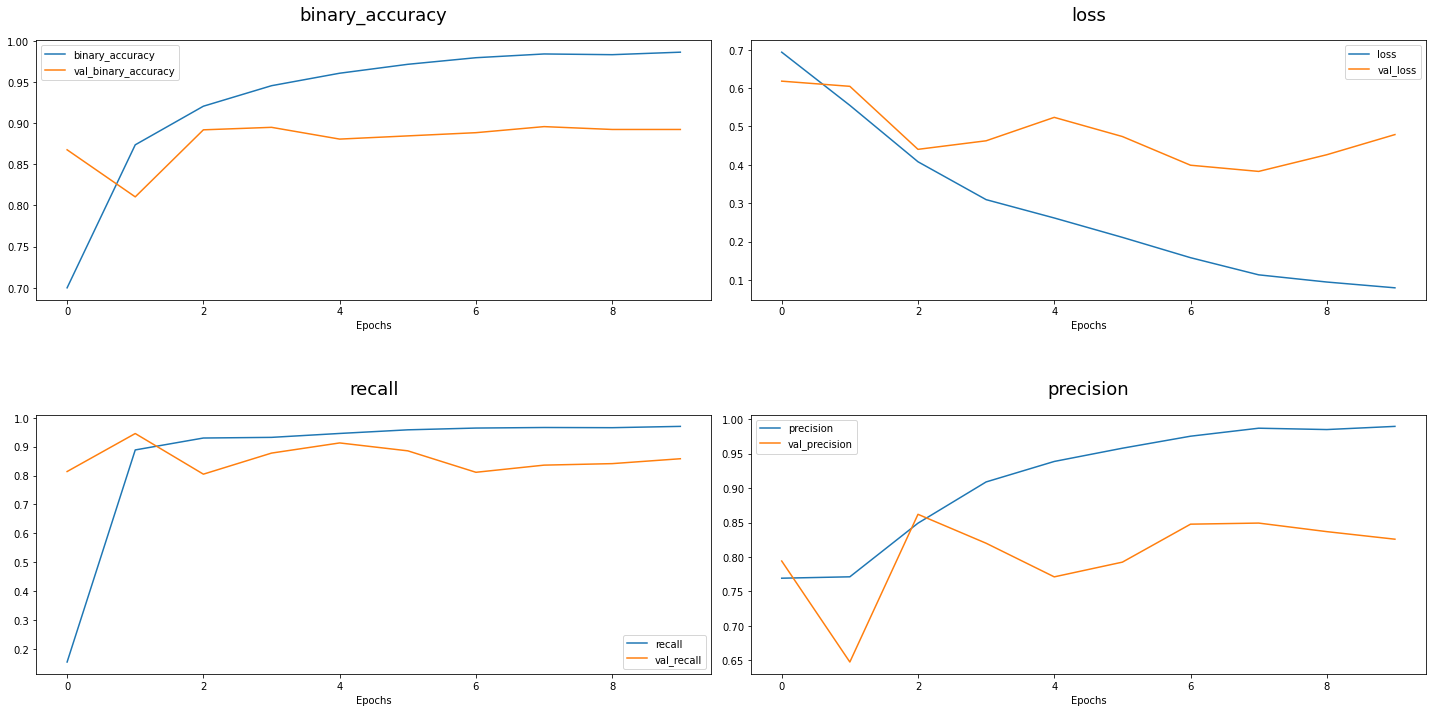

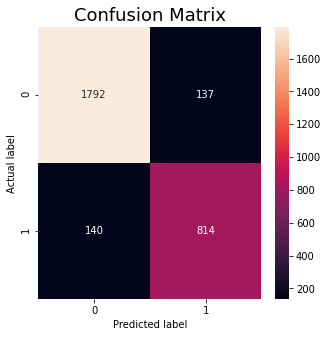

In [6]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)